In [2]:
import sys

sys.path.append('/content/drive/My Drive/Master Thesis Spring 2024')

from preprocessing import preprocessing_histgrad, preprocessing_PLS_RENT

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.optimize import differential_evolution

# OPTIMIZATION MODEL 1 USING HGBR

In [4]:
X_train, Y_train, X_test, Y_test, df_encoded = preprocessing_histgrad("TINE.Ystekar.Norvegia.v1.csv", train_index=1459)

In [5]:
# Define the uncontrollable, controllable and the interaction parameters
uncontrollable_parameters = [
    'Bu_start2casomaticTime',
    'Yk_start2endTime', 'Yk_mengde', 'Bu_duration','Yk_timeCoag','Yk_timeYstevann']

controllable_parameteres = [
    'Bs_Mengde', 'Yk_coagToCutAvgT',
    'Yk_ystevannToTommingAvgT', 'Bu_tempmean']

transformation_parameters = [
    'Bu_duration * Bu_tempmean',
    'Yk_timecoag*Yk_coagToCutAvgT', 'Yk_timeYstevann*Yk_ystevannToTommingAvgT']

for df in [X_train, X_test]:
    df['Bu_duration * Bu_tempmean'] = df['Bu_duration'] * df['Bu_tempmean']
    df['Yk_timecoag*Yk_coagToCutAvgT'] = df['Yk_timeCoag'] * df['Yk_coagToCutAvgT']
    df['Yk_timeYstevann*Yk_ystevannToTommingAvgT'] = df['Yk_timeYstevann'] * df['Yk_ystevannToTommingAvgT']

X_train_2 = X_train[uncontrollable_parameters + controllable_parameteres + transformation_parameters]
X_test_2 = X_test[uncontrollable_parameters + controllable_parameteres + transformation_parameters]

groups = X_train['Bs_Batch'].values

# Modelling using HGBR
hgb_model = HistGradientBoostingRegressor(max_depth=1, max_iter=200,learning_rate=0.2,min_samples_leaf=1,max_bins=200)

y_cv_pred = cross_val_predict(hgb_model, X_train_2, Y_train, groups=groups, cv=LeaveOneGroupOut())

r2_cv = r2_score(Y_train, y_cv_pred)

mse_cv = mean_squared_error(Y_train, y_cv_pred)

hgb_model.fit(X_train_2, Y_train)

# Predicting
y_train_pred = hgb_model.predict(X_train_2)
y_test_pred = hgb_model.predict(X_test_2)

# Evaluation
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test = mean_squared_error(Y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(Y_train, y_train_pred)
r2_test = r2_score(Y_test, y_test_pred)

print(f"Cross-validation - Average R²: {r2_cv:.4f}, Average MSE: {mse_cv:.4f}")
print(f"Training set - RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
print(f"Test set - RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")

Cross-validation - Average R²: 0.5054, Average MSE: 0.1377
Training set - RMSE: 0.2671, R²: 0.7438
Test set - RMSE: 0.4310, R²: 0.5327


In [7]:
# Setup bounds and indices for optimization of controllable parameters
# This will be censored due to sensitive information
bounds = [(X, X), (X, X), (X, X), (X, X)]
indices_of_controllable = [X_train_2.columns.get_loc(param) for param in controllable_parameteres]

# Convert dataframes to numpy arrays for processing
X_train_2 = np.array(X_train_2)
X_test_2 = np.array(X_test_2)

def objective_function(params, X_single, model, indices_of_controllable):
    try:
        # Update the dictionary with the new parameters
        X_updated = X_single.copy()
        for i, idx in enumerate(indices_of_controllable):
            X_updated[model.feature_names_in_[idx]] = params[i]

        # Convert to DataFrame for prediction
        df_single = pd.DataFrame([X_updated])
        prediction = model.predict(df_single)[0]

        # Penalty calculation
        if prediction < 57.6:
            return float((57.6 - prediction) ** 2)
        elif prediction > 57.7:
            return float((prediction - 57.7) ** 2)
        return 0.0
    except Exception as e:
        print(f"Error during prediction or data handling: {e}")
        return float('inf')

# The function for optimizing every sample in the test set
def optimize_per_sample(X, model, bounds, indices_of_controllable):
    optimized_params_per_sample = []
    for x_values in X:
        x_dict = {model.feature_names_in_[j]: x_values[j] for j in range(X.shape[1])}
        result = differential_evolution(
            objective_function,
            bounds=bounds,
            args=(x_dict, model, indices_of_controllable),
            strategy='randtobest1bin',
            maxiter=10,
            popsize=50,
            tol=0.01,
            mutation=(0.2, 1),
            recombination=0.9,
            seed=42
        )
        optimized_params_per_sample.append(result.x)
    return np.array(optimized_params_per_sample)


# Run the optimization
optimized_params = optimize_per_sample(np.array(X_test_2), hgb_model, bounds, indices_of_controllable)

# Generate predictions using optimized parameters and visualize results
optimized_predictions = []
for i in range(len(X_test_2)):
    test_sample = X_test_2[i].copy()
    for j, index in enumerate(indices_of_controllable):
        test_sample[index] = optimized_params[i][j]
    optimized_pred = hgb_model.predict(test_sample.reshape(1, -1))
    optimized_predictions.append(optimized_pred[0])

optimized_predictions = np.array(optimized_predictions)


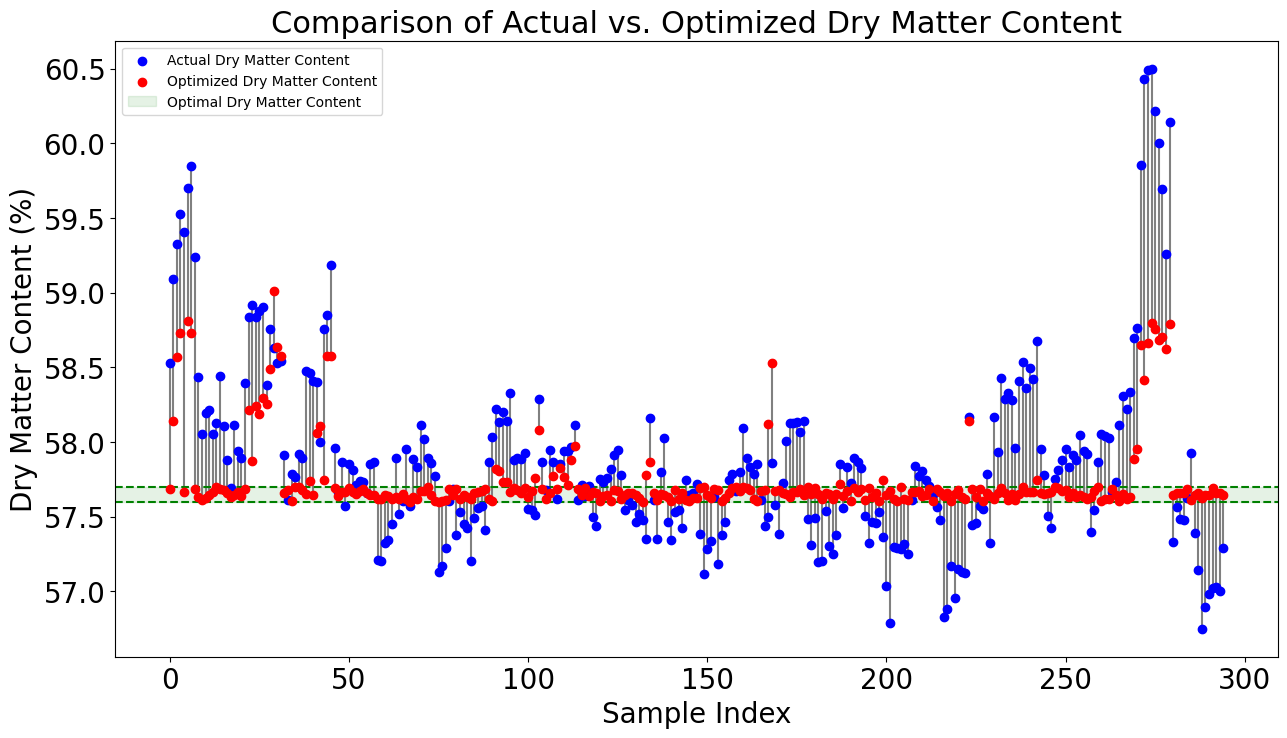

In [8]:
actual_dry_matter_contents = Y_test.tolist()
optimized_results = optimized_predictions

fig, ax = plt.subplots(figsize=(15, 8))

# Convert the lists to floats
actual_dry_matter_contents = [float(x) for x in actual_dry_matter_contents]
optimized_results = [float(x) for x in optimized_results]

# Plot lines between actual and optimized results
for i, (actual, optimized) in enumerate(zip(actual_dry_matter_contents, optimized_results)):
    ax.plot([i, i], [actual, optimized], color='grey', linestyle='-', marker='o', markersize=5)

# Scatter plots for actual and optimized results
ax.scatter(range(len(actual_dry_matter_contents)), actual_dry_matter_contents, color='blue', label='Actual Dry Matter Content', zorder=5)
ax.scatter(range(len(optimized_results)), optimized_results, color='red', label='Optimized Dry Matter Content', zorder=5)

# Set target bounds
target_lower = 57.6
target_upper = 57.7
ax.axhline(y=target_lower, color='green', linestyle='--')
ax.axhline(y=target_upper, color='green', linestyle='--')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin - 0.5, xmax + 0.5)
ax.fill_betweenx([target_lower, target_upper], xmin - 0.5, xmax + 0.5, color='green', alpha=0.1, label='Optimal Dry Matter Content')

# Set titles and labels
ax.set_title('Comparison of Actual vs. Optimized Dry Matter Content', fontsize=22)
ax.set_xlabel('Sample Index', fontsize=20)
ax.set_ylabel('Dry Matter Content (%)', fontsize=20)
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [9]:
def calculate_improvement_metrics(actual, optimized, target_lower=57.6, target_upper=57.7):
    improvement_count = 0
    total_within_target_before = 0
    total_within_target_after = 0

    for actual_val, optimized_val in zip(actual, optimized):
        # Check if actual and optimized values are within the target range
        is_actual_within = target_lower <= actual_val <= target_upper
        is_optimized_within = target_lower <= optimized_val <= target_upper

        # Count how many are within the target range before and after optimization
        if is_actual_within:
            total_within_target_before += 1
        if is_optimized_within:
            total_within_target_after += 1

        # Increment improvement count if the optimized value is closer to the range than the actual value
        if not is_actual_within and is_optimized_within:
            improvement_count += 1

    total_observations = len(actual)
    improvement_score = improvement_count
    accuracy_percentage = (improvement_count / total_observations) * 100
    within_target_improvement = (total_within_target_after / total_observations) * 100

    return improvement_score, accuracy_percentage, total_within_target_before, total_within_target_after, within_target_improvement
# Assuming Y_test and optimized_predictions are available and contain relevant data
improvement_score, accuracy_percentage, count_before, count_after, within_target_improvement = calculate_improvement_metrics(Y_test, optimized_predictions)

print(f"Improvement Score: {improvement_score} / {len(Y_test)}")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")
print(f"Count within target before: {count_before}")
print(f"Count within target after: {count_after}")
print(f"Improvement within target: {within_target_improvement:.2f}%")


Improvement Score: 221 / 295
Accuracy Percentage: 74.92%
Count within target before: 22
Count within target after: 243
Improvement within target: 82.37%


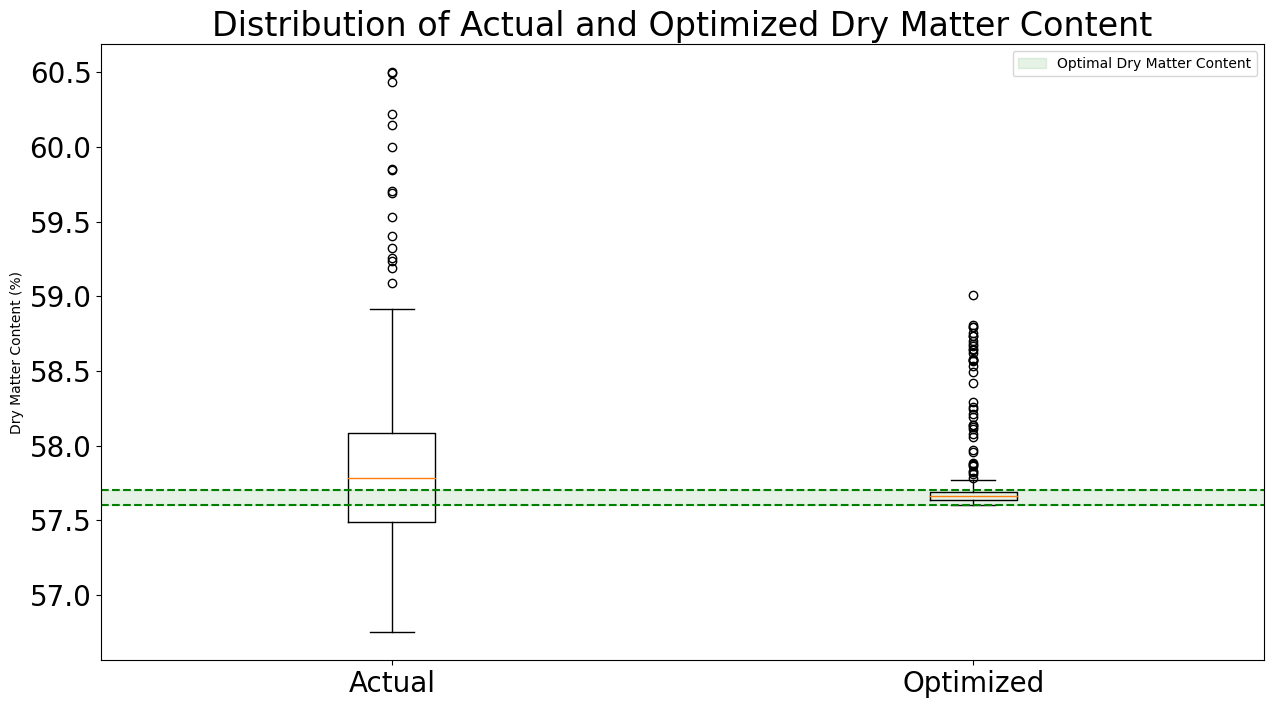

In [10]:
plt.figure(figsize=(15, 8))
plt.boxplot([actual_dry_matter_contents, optimized_predictions], labels=['Actual', 'Optimized'])

# Set target bounds
target_lower = 57.6
target_upper = 57.7


plt.axhline(y=target_lower, color='green', linestyle='--')
plt.axhline(y=target_upper, color='green', linestyle='--')
xmin, xmax = plt.xlim()
plt.fill_betweenx([target_lower, target_upper], xmin, xmax, color='green', alpha=0.1, label='Optimal Dry Matter Content')
plt.title('Distribution of Actual and Optimized Dry Matter Content', fontsize=24)
plt.ylabel('Dry Matter Content (%)')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()
plt.show()



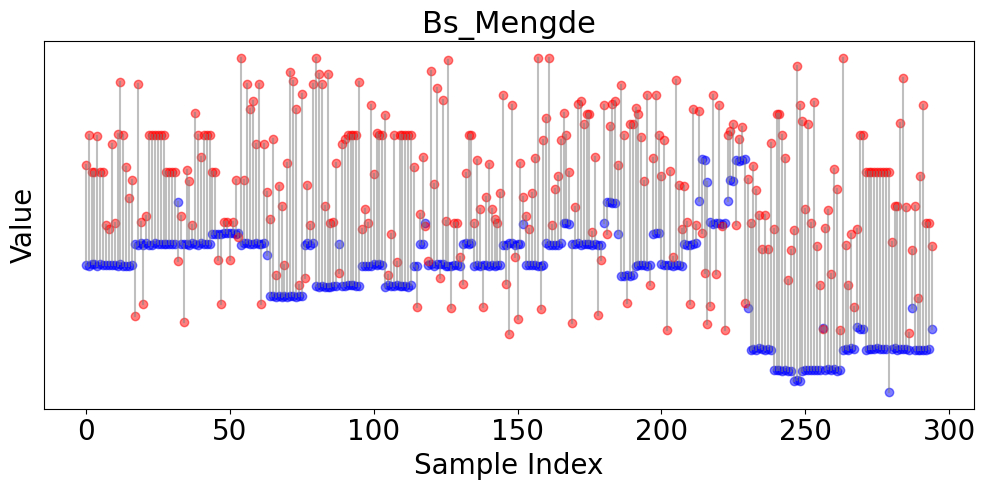

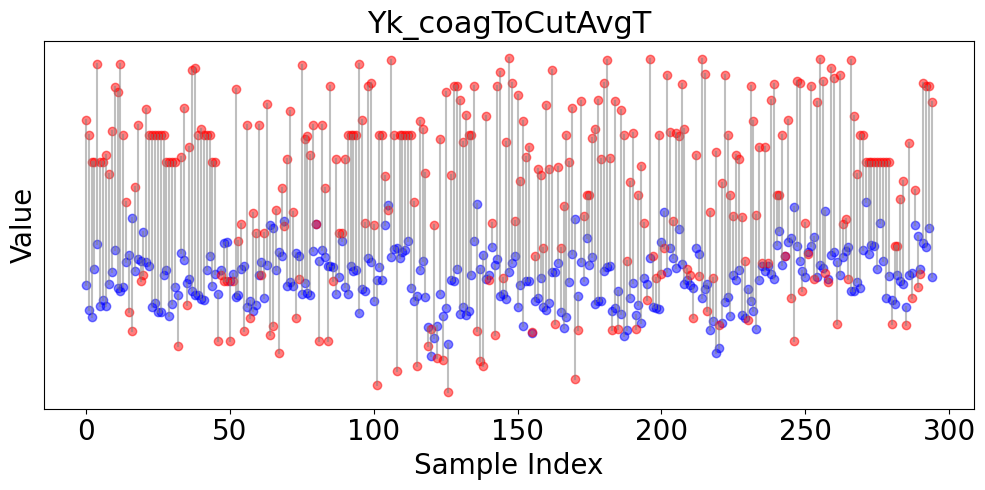

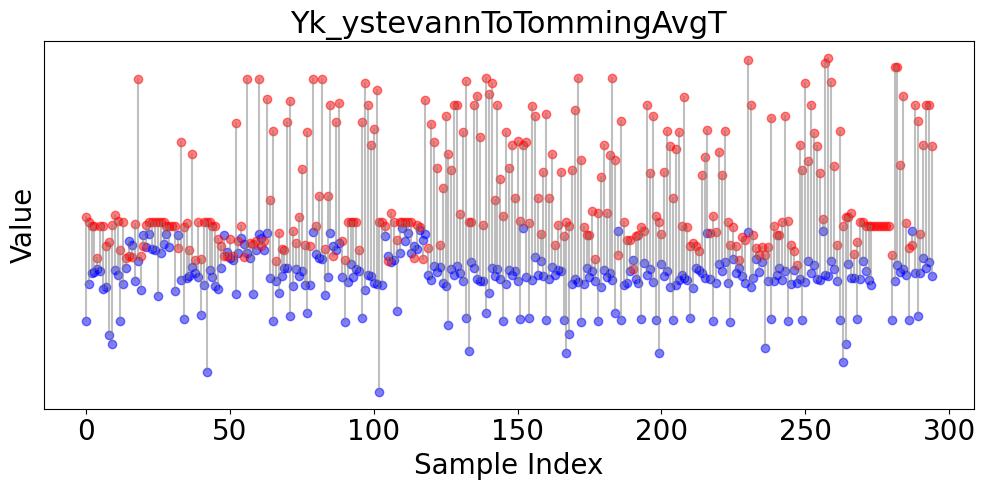

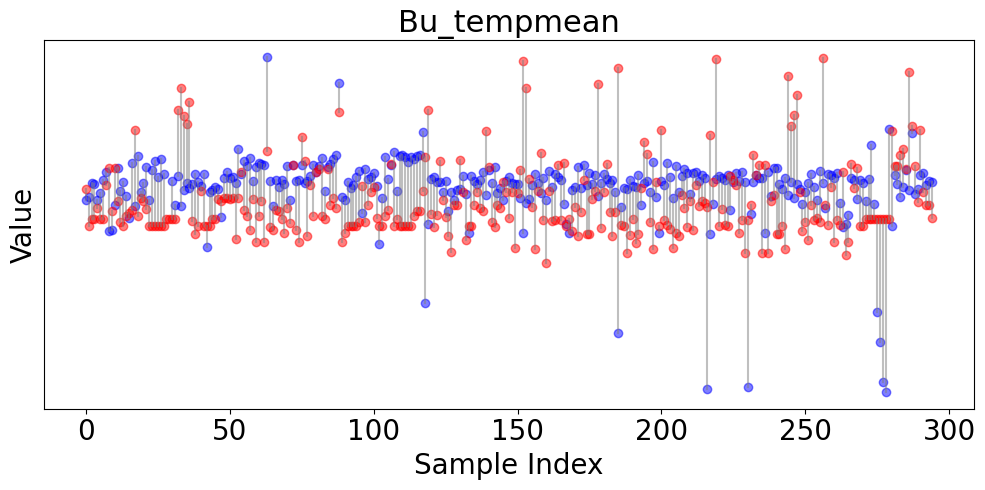

In [11]:
def visualize_parameter_changes(X_original, optimized_params_per_sample, indices_of_controllable, controllable_parameter_names):
    # Check if optimized_params_per_sample is 1-dimensional and reshape if necessary
    if optimized_params_per_sample.ndim == 1:
        optimized_params_per_sample = optimized_params_per_sample.reshape(-1, len(indices_of_controllable))

    n_samples, n_parameters = X_original.shape[0], len(indices_of_controllable)

    # Iterate through each controllable parameter
    for i, index in enumerate(indices_of_controllable):
        # Create a new figure for each parameter
        fig, ax = plt.subplots(figsize=(10, 5))

        # Use indexing suitable for numpy arrays
        original_values = X_original[:, index]
        optimized_values = optimized_params_per_sample[:, i]

        # Plot original and optimized values for each sample
        ax.scatter(range(n_samples), original_values, color='blue', alpha=0.5)
        ax.scatter(range(n_samples), optimized_values, color='red', alpha=0.5)

        # Draw lines between original and optimized values
        for sample_index in range(n_samples):
            ax.plot([sample_index, sample_index], [original_values[sample_index], optimized_values[sample_index]], 'gray', alpha=0.5)

        ax.set_title(f'{controllable_parameter_names[i]}', fontsize=22)
        ax.set_xlabel('Sample Index', fontsize=20)
        ax.set_ylabel('Value', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_yticks([])

        plt.tight_layout()
        plt.show()

visualize_parameter_changes(X_test_2, optimized_params, indices_of_controllable, controllable_parameteres)


# OPTIMIZTION MODEL USING PLSR

In [12]:
X_train, Y_train, X_test, Y_test, df_encoded = preprocessing_PLS_RENT("TINE.Ystekar.Norvegia.v1.csv", train_index=1459)

In [22]:
# Define lists of feature names for uncontrollable and controllable parameters
uncontrollable_parameters = [
    'Bu_start2casomaticTime', 'Yk_start2endTime', 'Yk_mengde', 'Bu_duration', 'Yk_timeCoag', 'Yk_timeYstevann']

controllable_parameters = [
    'Bs_Mengde', 'Yk_coagToCutAvgT', 'Yk_ystevannToTommingAvgT', 'Bu_tempmean']

# Define transformation parameters that are products of related features
transformation_parameters = [
    'Bu_duration * Bu_tempmean', 'Yk_timecoag*Yk_coagToCutAvgT', 'Yk_timeYstevann*Yk_ystevannToTommingAvgT']

# Calculate interaction terms for both training and testing datasets
for df in [X_train, X_test]:
    df['Bu_duration * Bu_tempmean'] = df['Bu_duration'] * df['Bu_tempmean']
    df['Yk_timecoag*Yk_coagToCutAvgT'] = df['Yk_timeCoag'] * df['Yk_coagToCutAvgT']
    df['Yk_timeYstevann*Yk_ystevannToTommingAvgT'] = df['Yk_timeYstevann'] * df['Yk_ystevannToTommingAvgT']

# Combine original and transformed features for model input
X_train_2 = X_train[uncontrollable_parameters + controllable_parameters + transformation_parameters]
X_test_2 = X_test[uncontrollable_parameters + controllable_parameters + transformation_parameters]

# Extract batch group identifiers for cross-validation
groups = X_train['Bs_Batch'].values

# Initialize PLS Regression with 4 principal components. The components was found manually, that gave the best test score on R-squared.
pls = PLSRegression(n_components=4, scale=True)

# Perform cross-validation using Leave-One-Group-Out strategy
y_cv_pred = cross_val_predict(pls, X_train_2, Y_train, groups=groups, cv=LeaveOneGroupOut())

# Calculate R² and MSE for cross-validation predictions
r2_cv = r2_score(Y_train, y_cv_pred)
mse_cv = mean_squared_error(Y_train, y_cv_pred)

# Fit PLS model to training data
pls.fit(X_train_2, Y_train)

# Make predictions on training and testing datasets
y_train_pred = pls.predict(X_train_2)
y_test_pred = pls.predict(X_test_2)

# Calculate MSE and RMSE for training and testing datasets
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test = mean_squared_error(Y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calculate R² scores for training and testing datasets
r2_train = r2_score(Y_train, y_train_pred)
r2_test = r2_score(Y_test, y_test_pred)

# Output model performance metrics
print(f"Using PLS with 4 components")  # Note: Ensure this matches n_components if different.
print(f"Cross-validation - Average R²: {r2_cv:.4f}, Average MSE: {mse_cv:.4f}")
print(f"Training set - RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
print(f"Test set - RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")



Using PLS with 4 components
Cross-validation - Average R²: 0.4922, Average MSE: 0.1414
Training set - RMSE: 0.3555, R²: 0.5461
Test set - RMSE: 0.4344, R²: 0.5252


In [23]:
# Setup bounds and indices for optimization of controllable parameters
# This will be censored due to sensitive information
bounds = [(X, X), (X, X), (X, X), (X, X)]
indices_of_controllable = [X_train_2.columns.get_loc(param) for param in controllable_parameters]

# Convert dataframes to numpy arrays for processing
X_train_2 = np.array(X_train_2)
X_test_2 = np.array(X_test_2)

def objective_function(params, X_single, model, indices_of_controllable):
    try:
        # Update the dictionary with the new parameters
        X_updated = X_single.copy()
        for i, idx in enumerate(indices_of_controllable):
            X_updated[model.feature_names_in_[idx]] = params[i]

        # Convert to DataFrame for prediction
        df_single = pd.DataFrame([X_updated])
        prediction = model.predict(df_single)[0]

        # Penalty calculation
        if prediction < 57.6:
            return float((57.6 - prediction) ** 2)
        elif prediction > 57.7:
            return float((prediction - 57.7) ** 2)
        return 0.0
    except Exception as e:
        print(f"Error during prediction or data handling: {e}")
        return float('inf')

# The function optimizes the controllable variables using the DE and the objective function
def optimize_per_sample(X, model, bounds, indices_of_controllable):
    optimized_params_per_sample = []
    for x_values in X:
        x_dict = {model.feature_names_in_[j]: x_values[j] for j in range(X.shape[1])}
        result = differential_evolution(
            objective_function,
            bounds=bounds,
            args=(x_dict, model, indices_of_controllable),
            strategy='randtobest1bin',
            maxiter=10,
            popsize=50,
            tol=0.01,
            mutation=(0.2, 1),
            recombination=0.9,
            seed=42
        )
        optimized_params_per_sample.append(result.x)
    return np.array(optimized_params_per_sample)


# Run the optimization
optimized_params = optimize_per_sample(np.array(X_test_2), pls, bounds, indices_of_controllable)


# Generate predictions using optimized parameters and visualize results
optimized_predictions = []
for i in range(len(X_test_2)):
    test_sample = X_test_2[i].copy()
    for j, index in enumerate(indices_of_controllable):
        test_sample[index] = optimized_params[i][j]
    optimized_pred = pls.predict(test_sample.reshape(1, -1))
    optimized_predictions.append(optimized_pred[0])

optimized_predictions = np.array(optimized_predictions)



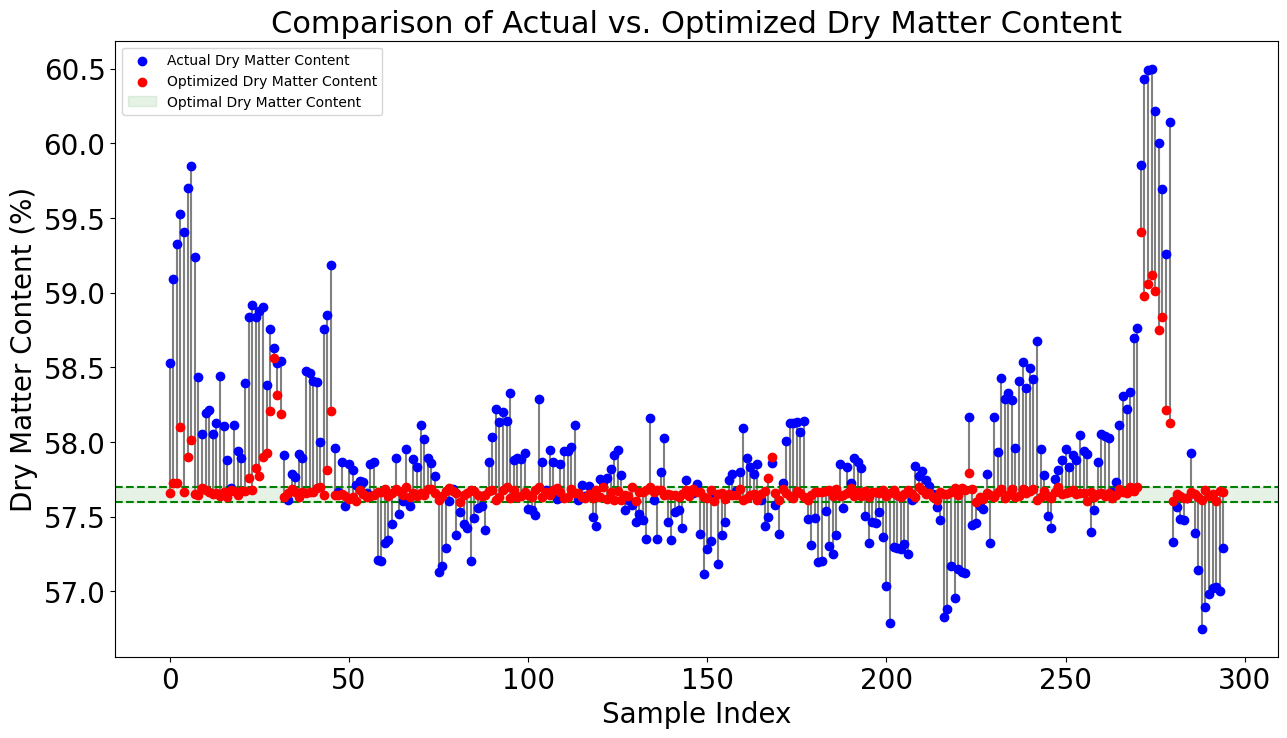

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))

actual_dry_matter_contents = Y_test.tolist()
optimized_results = optimized_predictions

# Convert the lists to floats
actual_dry_matter_contents = [float(x) for x in actual_dry_matter_contents]
optimized_results = [float(x) for x in optimized_results]

# Plot lines between actual and optimized results
for i, (actual, optimized) in enumerate(zip(actual_dry_matter_contents, optimized_results)):
    ax.plot([i, i], [actual, optimized], color='grey', linestyle='-', marker='o', markersize=5)

# Scatter plots for actual and optimized results
ax.scatter(range(len(actual_dry_matter_contents)), actual_dry_matter_contents, color='blue', label='Actual Dry Matter Content', zorder=5)
ax.scatter(range(len(optimized_results)), optimized_results, color='red', label='Optimized Dry Matter Content', zorder=5)

# Set target bounds
target_lower = 57.6
target_upper = 57.7
ax.axhline(y=target_lower, color='green', linestyle='--')
ax.axhline(y=target_upper, color='green', linestyle='--')

# Extend the x-axis limits slightly for full coverage of the target range fill
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin - 0.5, xmax + 0.5)
ax.fill_betweenx([target_lower, target_upper], xmin - 0.5, xmax + 0.5, color='green', alpha=0.1, label='Optimal Dry Matter Content')
ax.set_title('Comparison of Actual vs. Optimized Dry Matter Content', fontsize=22)
ax.set_xlabel('Sample Index', fontsize=20)
ax.set_ylabel('Dry Matter Content (%)', fontsize=20)
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()


In [25]:
def calculate_improvement_metrics(actual, optimized, target_lower=57.6, target_upper=57.7):
    improvement_count = 0
    total_within_target_before = 0
    total_within_target_after = 0

    for actual_val, optimized_val in zip(actual, optimized):
        # Check if actual and optimized values are within the target range
        is_actual_within = target_lower <= actual_val <= target_upper
        is_optimized_within = target_lower <= optimized_val <= target_upper

        # Count how many are within the target range before and after optimization
        if is_actual_within:
            total_within_target_before += 1
        if is_optimized_within:
            total_within_target_after += 1

        # Increment improvement count if the optimized value is closer to the range than the actual value
        if not is_actual_within and is_optimized_within:
            improvement_count += 1

    total_observations = len(actual)
    improvement_score = improvement_count
    accuracy_percentage = (improvement_count / total_observations) * 100
    within_target_improvement = (total_within_target_after / total_observations) * 100

    return improvement_score, accuracy_percentage, total_within_target_before, total_within_target_after, within_target_improvement

# Assuming Y_test and optimized_predictions are available and contain relevant data
improvement_score, accuracy_percentage, before_count, after_count, within_target_improvement = calculate_improvement_metrics(Y_test, optimized_predictions)

print(f"Improvement Score: {improvement_score} / {len(Y_test)}")
print(f"Accuracy Percentage (improvement near target value): {accuracy_percentage:.2f}%")
print(f"Count within target range before: {before_count}")
print(f"Count within target range after: {after_count}")
print(f"Improvement within the target range: {within_target_improvement:.2f}%")



Improvement Score: 245 / 295
Accuracy Percentage (improvement near target value): 83.05%
Count within target range before: 22
Count within target range after: 267
Improvement within the target range: 90.51%


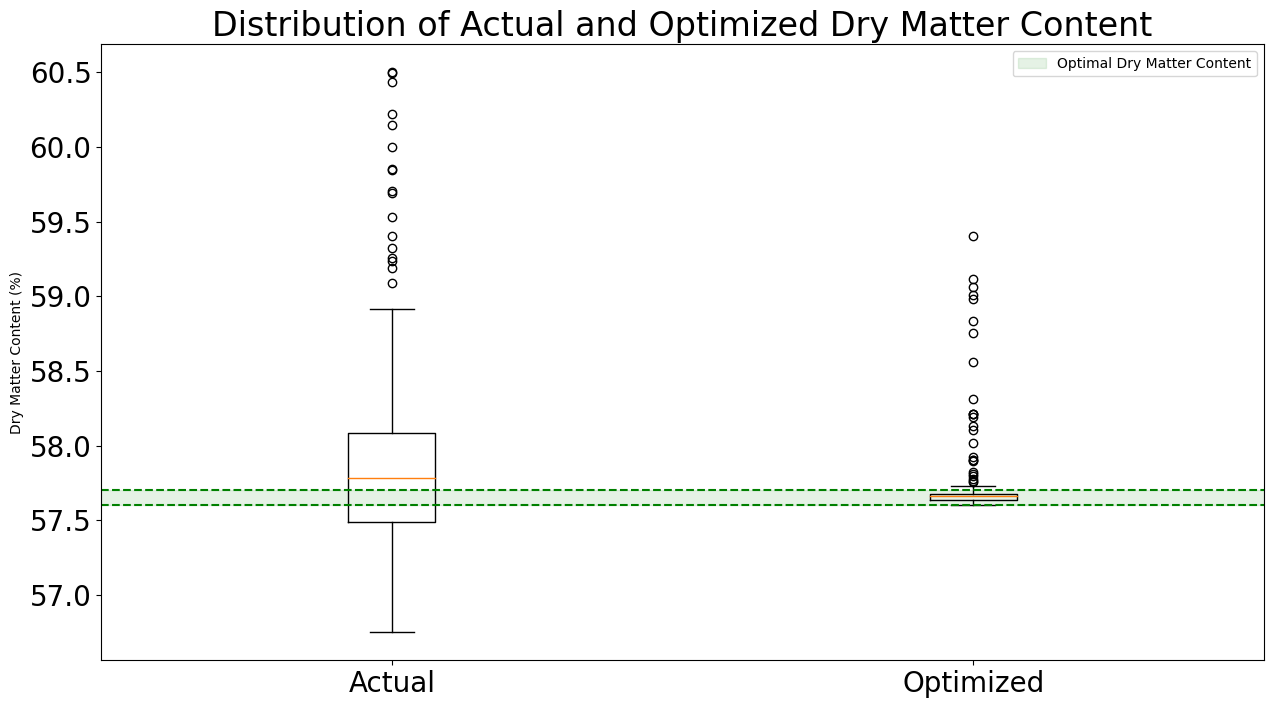

In [26]:
# Convert lists to numpy arrays
actual_dry_matter_contents = np.array(actual_dry_matter_contents)
optimized_predictions = np.array(optimized_predictions)

# Check if data is more than 1-dimensional and flatten if necessary
if actual_dry_matter_contents.ndim > 1:
    actual_dry_matter_contents = actual_dry_matter_contents.flatten()
if optimized_predictions.ndim > 1:
    optimized_predictions = optimized_predictions.flatten()

# Setup the figure and axis
plt.figure(figsize=(15, 8))

# Generate the boxplot
plt.boxplot([actual_dry_matter_contents, optimized_predictions], labels=['Actual', 'Optimized'])

# Set target bounds
target_lower = 57.6
target_upper = 57.7

# Add horizontal lines for the target range without labels
plt.axhline(y=target_lower, color='green', linestyle='--')
plt.axhline(y=target_upper, color='green', linestyle='--')
xmin, xmax = plt.xlim()
plt.fill_betweenx([target_lower, target_upper], xmin, xmax, color='green', alpha=0.1, label='Optimal Dry Matter Content')
plt.title('Distribution of Actual and Optimized Dry Matter Content', fontsize=24)
plt.ylabel('Dry Matter Content (%)')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()


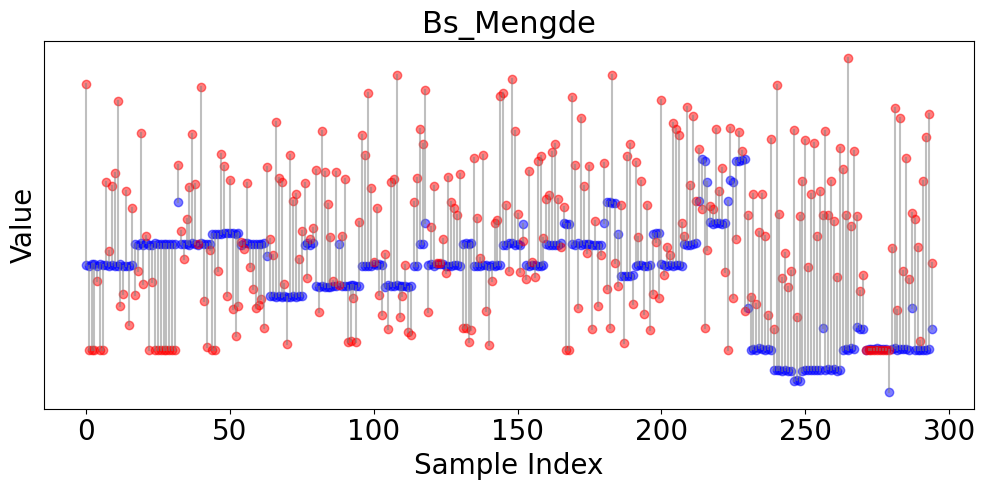

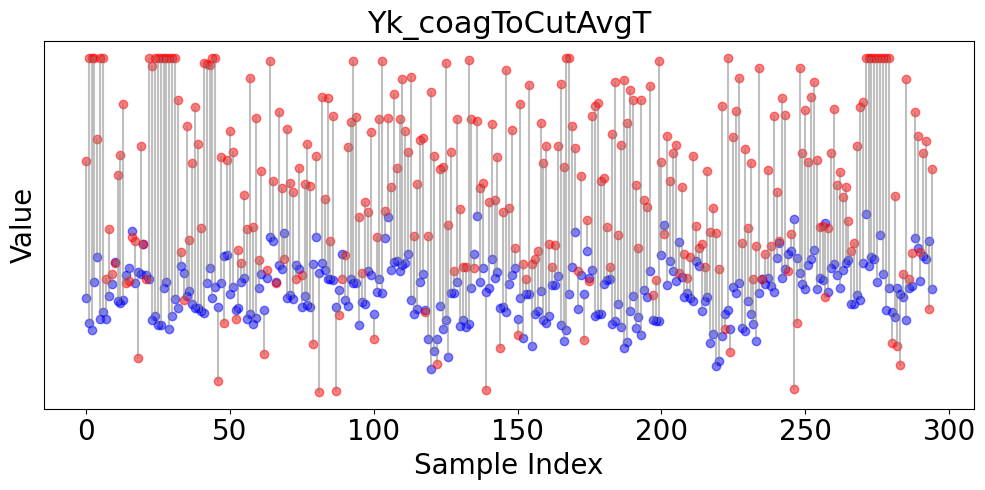

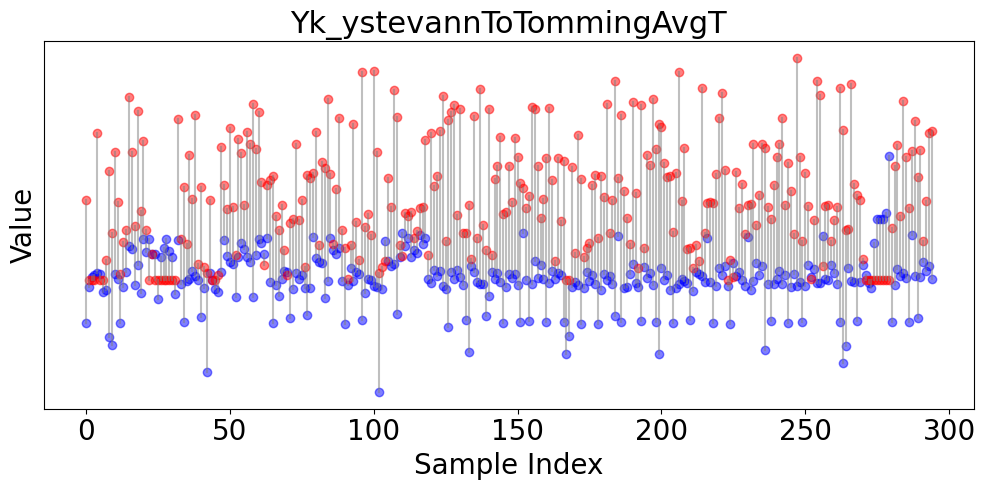

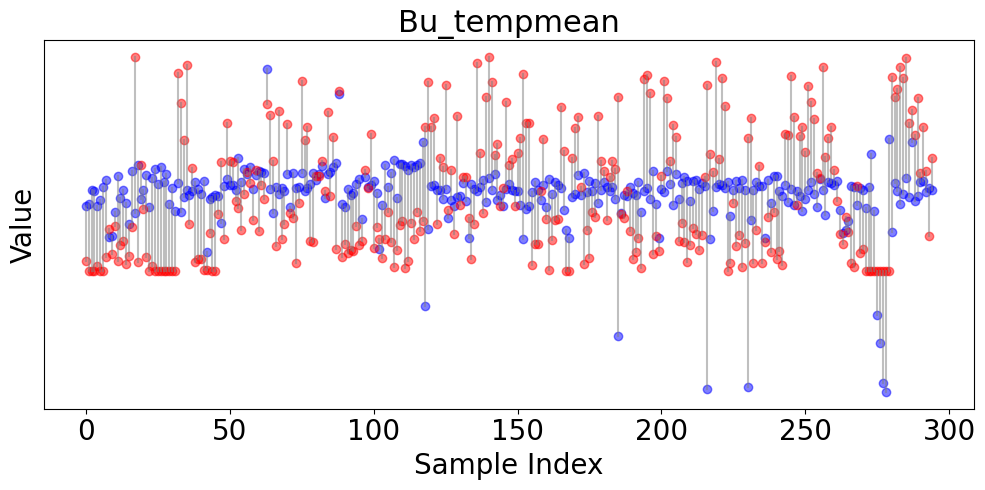

In [27]:
def visualize_parameter_changes(X_original, optimized_params_per_sample, indices_of_controllable, controllable_parameter_names):
    # Check if optimized_params_per_sample is 1-dimensional and reshape if necessary
    if optimized_params_per_sample.ndim == 1:
        optimized_params_per_sample = optimized_params_per_sample.reshape(-1, len(indices_of_controllable))

    n_samples, n_parameters = X_original.shape[0], len(indices_of_controllable)

    # Iterate through each controllable parameter
    for i, index in enumerate(indices_of_controllable):
        # Create a new figure for each parameter
        fig, ax = plt.subplots(figsize=(10, 5))

        # Use indexing suitable for numpy arrays
        original_values = X_original[:, index]
        optimized_values = optimized_params_per_sample[:, i]

        # Plot original and optimized values for each sample
        ax.scatter(range(n_samples), original_values, color='blue', alpha=0.5)
        ax.scatter(range(n_samples), optimized_values, color='red', alpha=0.5)

        # Draw lines between original and optimized values
        for sample_index in range(n_samples):
            ax.plot([sample_index, sample_index], [original_values[sample_index], optimized_values[sample_index]], 'gray', alpha=0.5)

        ax.set_title(f'{controllable_parameter_names[i]}', fontsize=22)
        ax.set_xlabel('Sample Index', fontsize=20)
        ax.set_ylabel('Value', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_yticks([])

        plt.tight_layout()
        plt.show()

visualize_parameter_changes(X_test_2, optimized_params, indices_of_controllable, controllable_parameteres)